In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
import traceback
import re
import pandas.core.algorithms as algos
from pandas import Series
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv('FinalWNVData v.1')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 72 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Block                   10506 non-null  int64  
 3   Street                  10506 non-null  object 
 4   Trap                    10506 non-null  object 
 5   AddressNumberAndStreet  10506 non-null  object 
 6   Latitude                10506 non-null  float64
 7   Longitude               10506 non-null  float64
 8   AddressAccuracy         10506 non-null  int64  
 9   NumMosquitos            10506 non-null  int64  
 10  WnvPresent              10506 non-null  int64  
 11  Tmax                    10506 non-null  float64
 12  Tmin                    10506 non-null  float64
 13  Tavg                    10506 non-null  float64
 14  Depart                  10506 non-null

# Weight of Evidence/Information Value

In [39]:
#First let's split our data into training and testing sets.
X = df.drop(columns=['WnvPresent'])
y = df['WnvPresent']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

In [6]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
            
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = np.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [40]:
final_iv, IV = data_vars(X_train,y_train)

Date
Address
Block
0   -0.017225
1    0.017073
dtype: float64
Street
Trap
AddressNumberAndStreet
Latitude
0     0.230493
1    -1.257677
2    -0.035210
3    -0.035210
4     0.134824
5    -0.488407
6    -0.438769
7     0.225982
8    -0.058275
9    -0.808400
10   -0.364856
11   -0.969995
12   -0.195059
13   -0.080113
14    0.192707
15    0.114064
16    0.637201
17         NaN
18    0.271315
19    0.096962
dtype: float64
Longitude
0    0.192852
1   -0.233564
dtype: float64


C:\Users\Smartjuice\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


AddressAccuracy
0    0.001668
1   -0.002725
dtype: float64
NumMosquitos
0   -2.097645
1   -0.890403
2    0.180770
3    1.006982
dtype: float64
Tmax
0   -0.005326
1    0.005612
dtype: float64
Tmin
0   -0.379902
1    0.287091
dtype: float64
Tavg
0   -0.093865
1    0.089392
dtype: float64
Depart
0   -0.342075
1    0.112600
2    0.186850
dtype: float64
DewPoint
0   -0.522542
1   -0.206358
2    0.494512
dtype: float64
WetBulb
0   -0.258213
1    0.213435
dtype: float64
Heat
0    0.116984
1   -2.076142
dtype: float64
Cool
0   -0.093865
1    0.089392
dtype: float64
Sunrise
Sunset
CodeSum
SnowFall
PrecipTotal
0    0.025189
1   -2.356290
dtype: float64
StnPressure
0    0.032504
1   -0.034340
dtype: float64
SeaLevel
0    0.051397
1   -0.062065
dtype: float64
ResultSpeed
0    0.166230
1   -0.073762
2   -0.128787
dtype: float64
ResultDir
0   -0.059085
1    0.065904
dtype: float64
AvgSpeed
0    0.074931
1   -0.090975
dtype: float64
BR
DZ
FG
HZ
RA
TS
TSRA
VCTS
CULEX ERRATICUS
CULEX PIPIENS
CULEX REST

In [8]:
IV.sort_values(by='IV',ascending=False)

,VAR_NAME,IV
35,NumMosquitos,1.162964e+00
48,Sunset,8.673407e-01
16,Date,8.631322e-01
47,Sunrise,7.510495e-01
3,August,4.615830e-01
...,...,...
1,AddressAccuracy,4.544828e-06
52,Thornton Township,2.967534e-06
69,Worth Township,5.815540e-07
11,CULEX TARSALIS,5.149380e-07


In [9]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
display(X2.shape)
X2.head()

(7354, 36)

,Address,AddressNumberAndStreet,August,BR,CULEX PIPIENS,CULEX RESTUANS,CodeSum,DZ,Depart,DewPoint,...,TimeSinceLastDZ,TimeSinceLastFG,TimeSinceLastHZ,TimeSinceLastTS,TimeSinceLastTSRA,TimeSinceLastVCTS,Tmin,Trap,VCTS,WetBulb
4115,"1000 North Central Park Avenue, Chicago, IL 60...","1000 N CENTRAL PARK DR, Chicago, IL",0,0,1,1,RA,0,-6.0,49.0,...,21.942014,67.63491,16.534598,27.275715,16.859256,26.365388,49.5,T030,0,55.0
9004,"1700 West Addison Street, Chicago, IL 60613, USA","1700 W ADDISON ST, Chicago, IL",0,1,1,1,TS BR,0,10.0,69.5,...,21.942014,67.63491,22.000000,0.000000,11.000000,26.365388,73.0,T224,0,75.0
3334,"4700 South Cornell Avenue, Chicago, IL 60615, USA","4700 S CORNELL AVE, Chicago, IL",0,0,1,0,,0,12.0,59.0,...,42.000000,113.00000,13.000000,26.000000,13.000000,43.000000,66.5,T075,0,65.0
8333,"4200 West 127th Street, Alsip, IL 60803, USA","4200 W 127TH PL, Chicago, IL",0,1,0,1,RA BR,0,5.0,64.0,...,21.942014,67.63491,16.534598,27.275715,0.000000,26.365388,69.0,T135,0,67.5
9021,"1700 North Ashland Avenue, Chicago, IL 60622, USA","1700 N ASHLAND AVE, Chicago, IL",0,1,1,1,TS BR,0,10.0,69.5,...,21.942014,67.63491,22.000000,0.000000,11.000000,26.365388,73.0,T232,0,75.0


In [41]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing Longitude with VIF of 350243.687628
Iteration # 2
Removing WetBulb with VIF of 9869.334821
Iteration # 3
Removing Tmin with VIF of 855.780510
Iteration # 4
Removing DewPoint with VIF of 500.374693
Iteration # 5
Removing Latitude with VIF of 77.118121
Iteration # 6
Removing TimeSinceLastFG with VIF of 21.741854
Iteration # 7
Removing TimeSinceLastVCTS with VIF of 13.920986
Iteration # 8
Removing TimeSinceLastTS with VIF of 11.173578
Iteration # 9
Removing TimeSinceLastDZ with VIF of 7.963530
Iteration # 10
Removing ResultSpeed with VIF of 5.583909
Iteration # 11
Complete


In [11]:
final_vif

,VIFactor,features
19,1.344110,VCTS
4,1.347007,DZ
13,1.404228,October
6,1.420003,FG
9,1.476727,Jefferson Township
15,1.945145,TS
12,2.094255,Monday
8,2.182098,Heat
11,2.230776,June
14,2.335790,PrecipTotal


In [12]:
final_df

,August,BR,CULEX PIPIENS,CULEX RESTUANS,DZ,Depart,FG,Friday,Heat,Jefferson Township,July,June,Monday,October,PrecipTotal,TS,Thursday,TimeSinceLastHZ,TimeSinceLastTSRA,VCTS
4115,0,0,1,1,0,-6.0,0,1,3.5,0,0,1,0,0,0.0050,0,0,16.534598,16.859256,0
9004,0,1,1,1,0,10.0,0,1,0.0,0,1,0,0,0,0.2925,1,0,22.000000,11.000000,0
3334,0,0,1,0,0,12.0,0,0,0.0,0,0,0,0,0,0.0000,0,0,13.000000,13.000000,0
8333,0,1,0,1,0,5.0,0,1,0.0,0,0,1,0,0,0.4500,0,0,16.534598,0.000000,0
9021,0,1,1,1,0,10.0,0,1,0.0,0,1,0,0,0,0.2925,1,0,22.000000,11.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0,0,1,1,0,7.0,0,0,0.0,0,0,0,1,0,0.0000,0,0,66.000000,52.000000,0
5191,0,0,1,1,0,-4.0,0,1,0.0,0,1,0,0,0,0.0000,0,0,21.000000,7.000000,0
5390,1,0,1,0,0,0.0,0,0,0.0,0,0,0,0,0,0.0000,0,1,34.000000,20.000000,0
860,1,0,1,0,0,8.0,0,0,0.0,0,0,0,0,0,0.0000,0,0,0.000000,14.000000,0


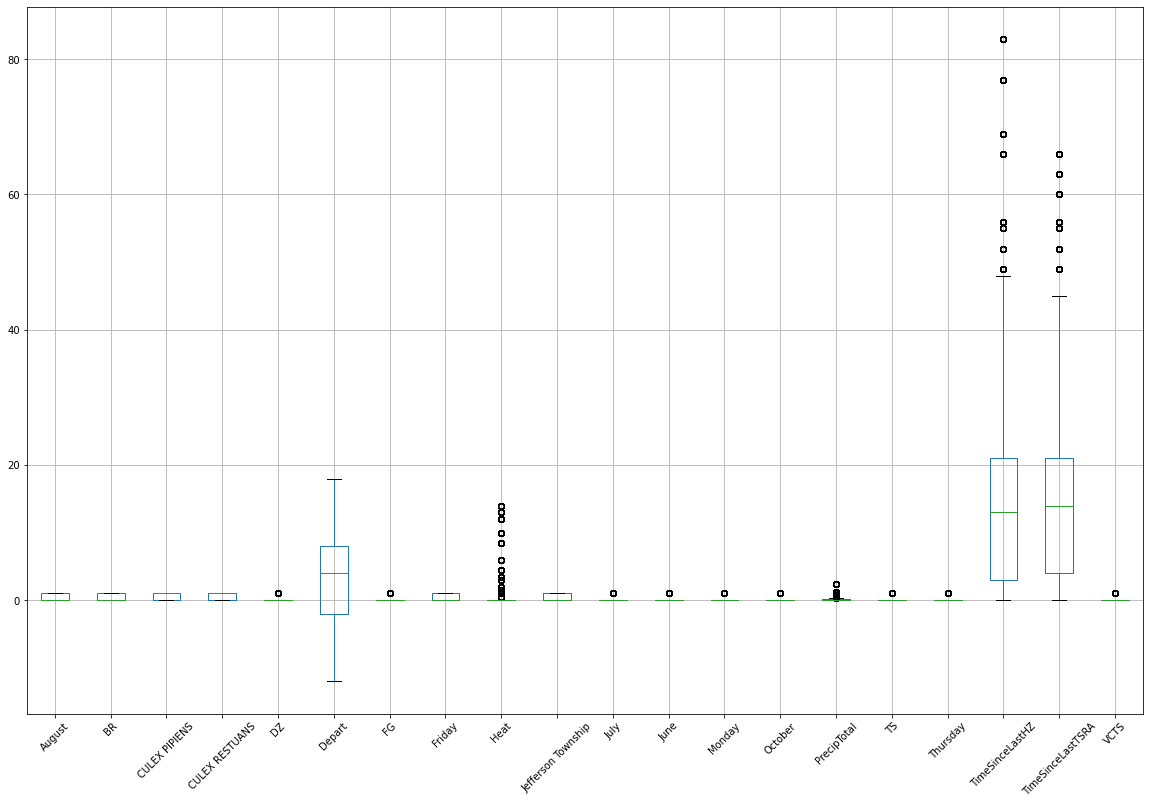

In [25]:
plt.figure(figsize=(20,13))
final_df.boxplot()
plt.xticks(rotation=45);

In [64]:
quantile = final_df['TimeSinceLastHZ'].quantile(.95)
trimmed_df = final_df[final_df['TimeSinceLastHZ']<quantile]
quantile = final_df['TimeSinceLastTSRA'].quantile(.95)
trimmed_df = trimmed_df[trimmed_df['TimeSinceLastTSRA']<quantile]
for index in set(y_train.index).difference(set(trimmed_df.index)):
    y_train.drop(index,inplace=True)

In [66]:
#Let's save this final dataframe now as our training data
trimmed_df.to_csv('X_train',index=False)
y_train.to_csv('y_train',index=False)
X_test.to_csv('X_test',index=False)
y_test.to_csv('y_test',index=False)